# Kalman filter for the Covid19 pandemic

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
from src.data import SirModel
from src.visualisation import plot_progress, plot_param_process, plot_error, plot_param_distribution

In [2]:
save_dir = '../figures/covid/kalman'

## SIR model for Covid19 pandemic
First of all load the data of the Covid19 pandemic in Germany between 06.05.2020 and 11.04.2022.

In [3]:
df_sir = pandas.read_csv("../data/covid19_sir.csv", index_col=0)
df_sir

,susceptible,infected,removed,vaccinated,population
06.05.2020,83035193.0,5980.0,158827.0,0.0,83200000.0
07.05.2020,83033909.0,5705.0,160386.0,0.0,83200000.0
08.05.2020,83032700.0,5394.0,161906.0,0.0,83200000.0
09.05.2020,83031449.0,5703.0,162848.0,0.0,83200000.0
10.05.2020,83030782.0,5715.0,163503.0,0.0,83200000.0
...,...,...,...,...,...
07.04.2022,60934212.0,1040481.0,21225307.0,59615114.0,83200000.0
08.04.2022,60758949.0,982220.0,21458831.0,59623432.0,83200000.0
09.04.2022,60608274.0,949500.0,21642226.0,59627259.0,83200000.0
10.04.2022,60552803.0,912992.0,21734205.0,59628513.0,83200000.0


Generate the a Sir model with an identical number of data $N$, end time $T$ and initial condition.
The parameters are chosen randomly.
Then the data can be replaced by by the observations from the covid 19 pandemic.

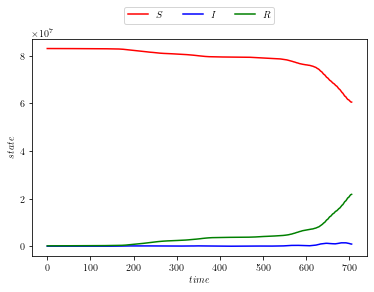

In [4]:
sir = SirModel(number_of_data=706,
               end_time=705,
               param = {'beta': 0.155, 'gamma': 1/7},
               initial_condition={'t': 0, 'y_1': 83029213.0, 'y_2': 5980.0, 'y_3': 164807.0})

new_sir_data = df_sir.reset_index().rename(columns={'susceptible': 'y_1', 'infected': 'y_2','removed': 'y_3'})[['y_1', 'y_2','y_3']]
sir.data = new_sir_data
sir.plot_data()

In [5]:
plt.rcParams.update({'font.size': 30,
                     'figure.figsize': (16, 8),
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{lmodern}', 
                     'font.weight': 'bold', 
                     "axes.labelweight": "bold"})

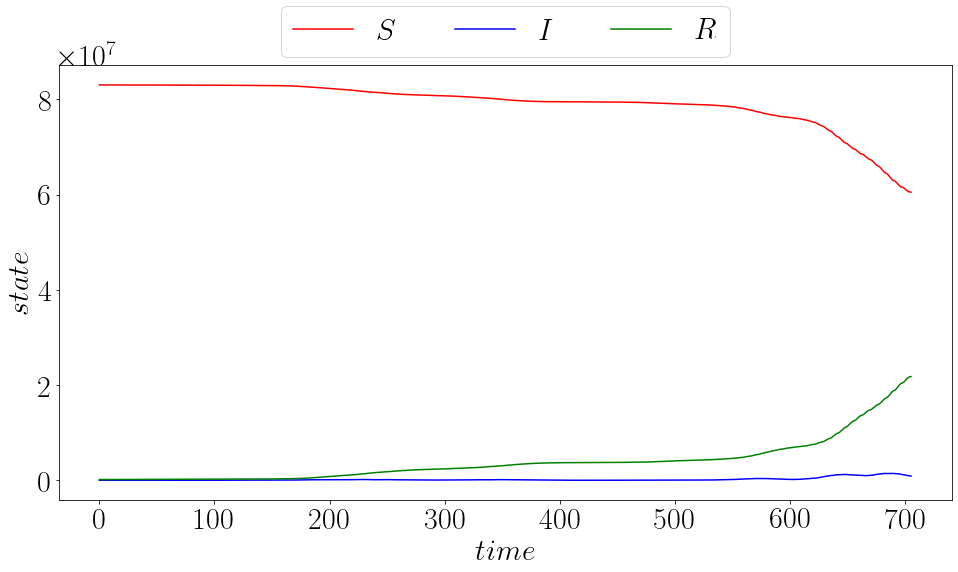

In [6]:
sir.plot_data(save_dir=save_dir)
sir.plot_data()

## Kalman filter
Since the data are already available, the kalman filter can now be created.

In [7]:
from src.kalmanfilter import KalmanFilter

In [8]:
kf = KalmanFilter(sir)

Now it just needs to be trained.

In [9]:
df_train_param = kf.train(epochs=50000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [02:25<00:00, 343.57it/s]


best parameter: {'beta': 0.20112023754512054, 'gamma': 0.1597545036169754}


In [10]:
analysis, forecast = kf.predict()

After that, we look at how well the states were predicted. As an aid, the predictions can be presented together with the observations and the underlying true values.

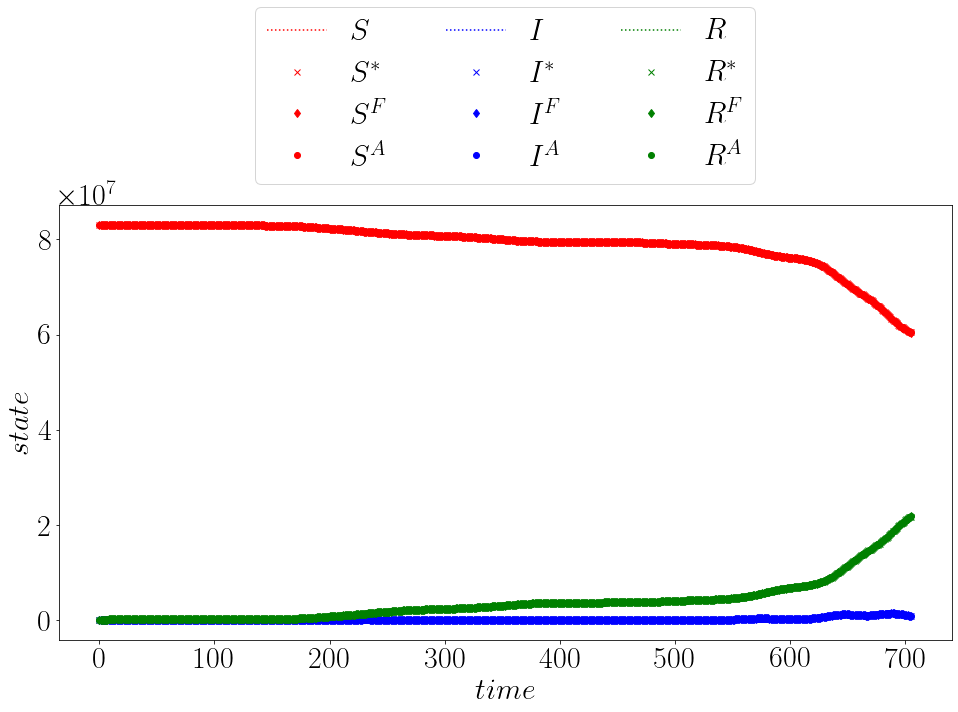

save figure to ../figures/covid/kalman/covid_kalman_progress


In [11]:
plot_progress(time=numpy.array([[t] for t in kf.input_data.index]),
              observation=kf.differential_equation.data,
              true=sir.data,
              prediction=forecast,
              analysis=analysis, 
              variables={'y_1': 'S', 'y_2': 'I', 'y_3': 'R'})
plot_progress(time=numpy.array([[t] for t in kf.input_data.index]),
              observation=kf.differential_equation.data,
              true=sir.data,
              prediction=forecast,
              analysis=analysis, 
              variables={'y_1': 'S', 'y_2': 'I', 'y_3': 'R'}, 
              save_path=f"{save_dir}/covid_kalman_progress")

Finally, we check how well the parameter estimation worked by plotting the development of the parameters over the epochs.
For comparison, the parameters with which the data were generated are also plotted.

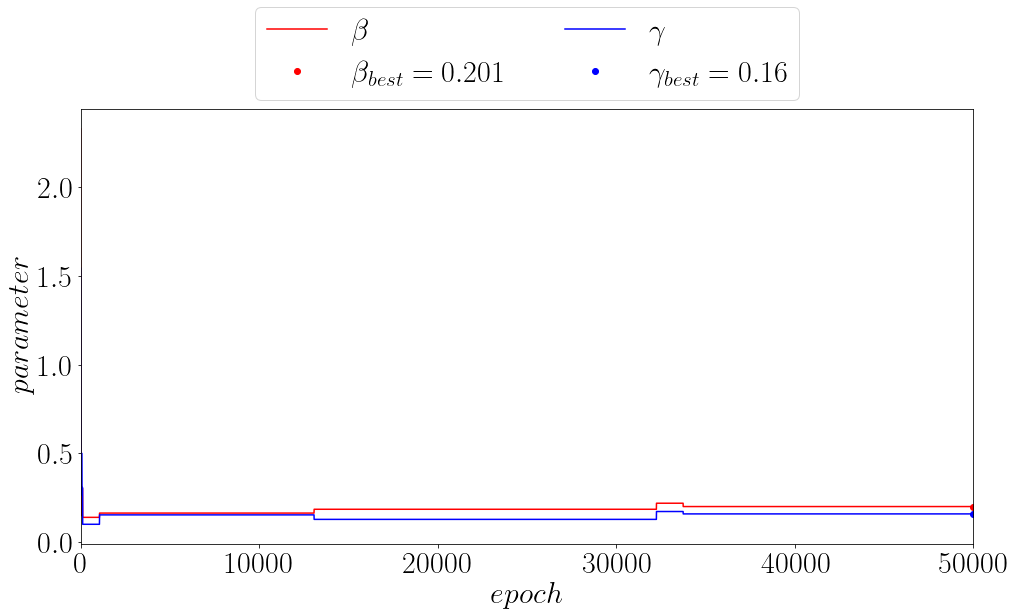

save figure to ../figures/covid/kalman/covid_kalman_param


In [12]:
plot_param_process(true_params=kf.differential_equation.param, 
                   df_progress=kf.df_progress, 
                   plot_true_params=False)
plot_param_process(true_params=kf.differential_equation.param, 
                   df_progress=kf.df_progress, 
                   plot_true_params=False, 
                   save_path=f"{save_dir}/covid_kalman_param")

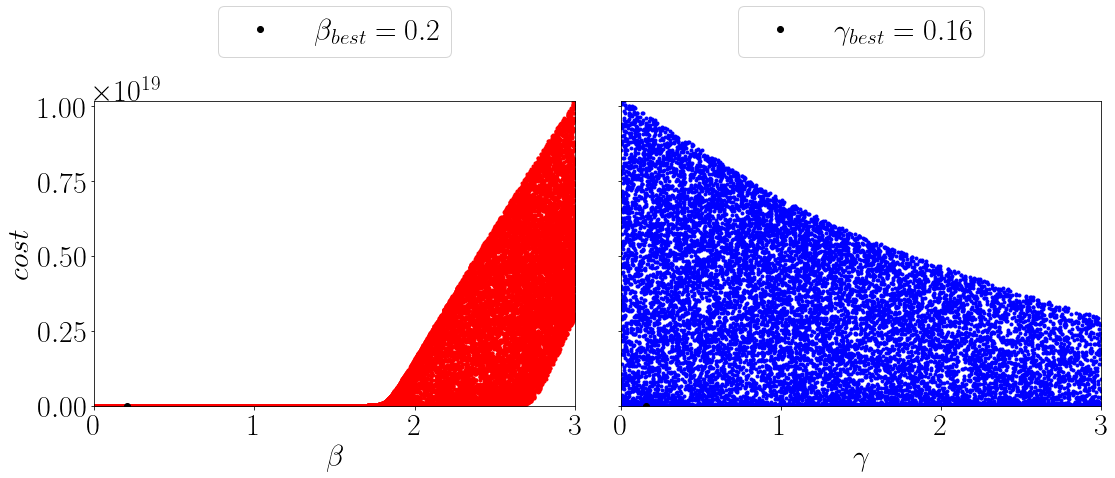

save figure to ../figures/covid/kalman/covid_kalman_param_distribution


In [13]:
plot_param_distribution(df_train_param, 
                        best_params=kf.df_progress.iloc[-1].to_dict(), 
                        name='sir')
plot_param_distribution(df_train_param, 
                        best_params=kf.df_progress.iloc[-1].to_dict(), 
                        name='sir',
                        save_path=f"{save_dir}/covid_kalman_param_distribution")

The cost per state is: 10954.240658373514.


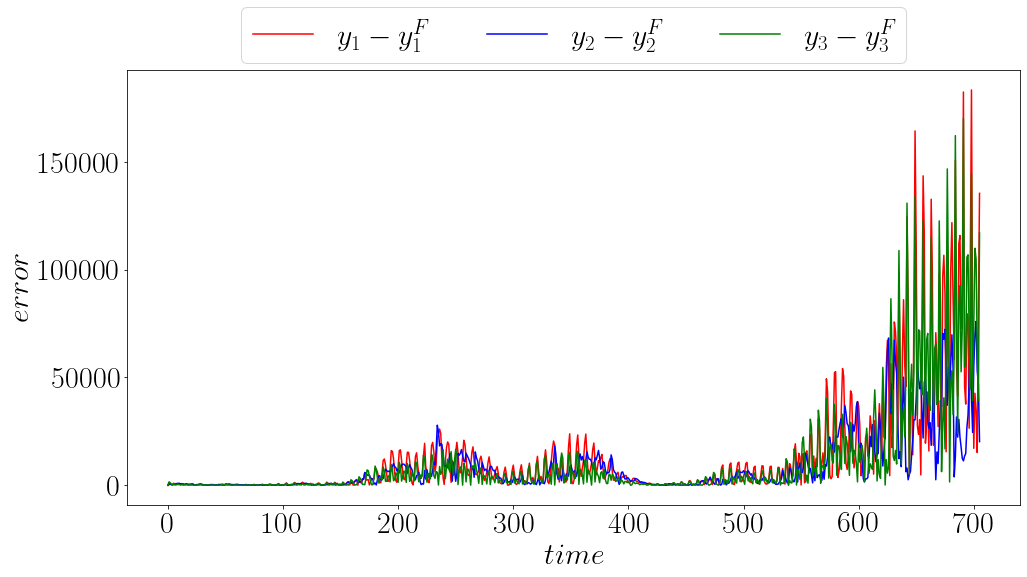

The cost per state is: 10954.240658373514.
save figure to ../figures/covid/kalman/covid_kalman_error


In [14]:
plot_error(sir.data, forecast[:,:3], name='kalman')
plot_error(sir.data, forecast[:,:3], name='kalman', 
           save_path=f"{save_dir}/covid_kalman_error")

## Check parameter estimation

In [15]:
estimated_params = kf.df_progress.iloc[-1].to_dict()

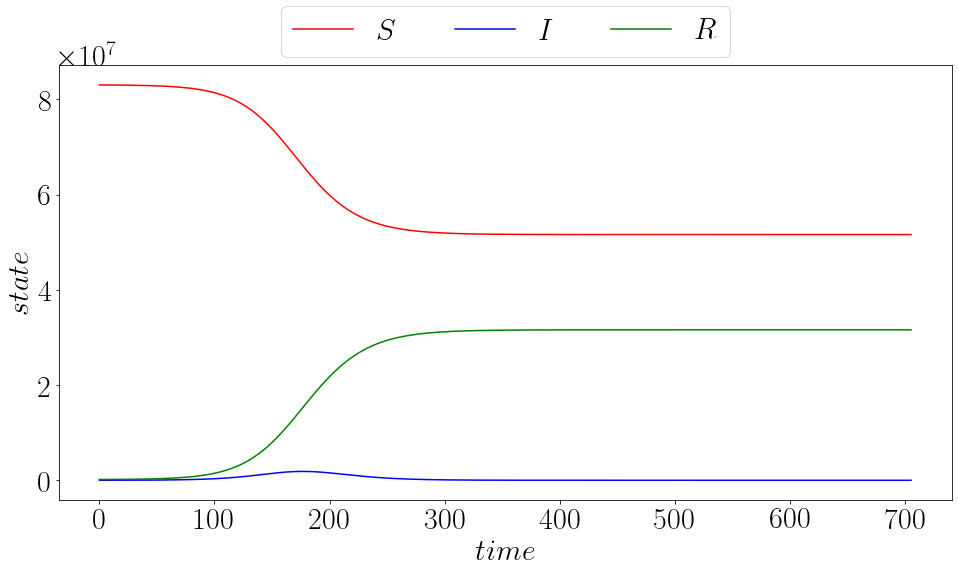

In [16]:
sir_estimate = SirModel(number_of_data=706,
                        end_time=705,
                        param = estimated_params,
                        initial_condition={'t': 0, 'y_1': 83029213.0, 'y_2': 5980.0, 'y_3': 164807.0})
sir_estimate.set_data()
sir_estimate.plot_data()